In [1]:
import os
os.chdir("..")

import json
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader

from glob import glob

from lib import *

import albumentations as albu

import segmentation_models_pytorch as smp
from utils.trainer import Trainer
from utils.data.datasets import CustomDataset
from utils.data.datasets import get_preprocessing
from utils.scorer import DiceLoss

In [2]:
train_path = "./data/train"
val_path = "./data/val"
test_path = "./data/real_test"

encoder = 'resnet50'
encoder_weights = 'imagenet'
device = 'cuda'
lr = 2e-5
batch_size = 10
num_workers = 0

In [3]:
model = smp.Unet(encoder_name=encoder)
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

In [4]:
augmentations = [albu.RandomRotate90(), 
                 albu.Flip(), 
                 albu.Transpose(),
                 albu.OneOf([albu.IAAAdditiveGaussianNoise(), 
                             albu.GaussNoise()], p=0.2),
                 albu.OneOf([albu.MotionBlur(p=0.2), 
                             albu.MedianBlur(blur_limit=3, p=0.1), 
                             albu.Blur(blur_limit=3, p=0.1)], p=0.2),
                 albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
                 albu.HueSaturationValue(p=0.3)]
transforms = albu.Compose(augmentations, p=0.5)

In [5]:
train_dataset = CustomDataset(data_path=train_path, transforms=transforms,\
                              preprocessing=get_preprocessing(preprocessing_fn))
val_dataset = CustomDataset(data_path=val_path, transforms=transforms,\
                            preprocessing=get_preprocessing(preprocessing_fn))
    
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [6]:
trainer = Trainer(model, device=device, model_name='unet')

In [7]:
trainer.train(train_dataloader=train_loader, val_dataloader=val_loader , n_epoch=10,\
              optim=torch.optim.Adam, weight_decay=0.0,\
              schedul=None, loss=DiceLoss(), lr=2e-5, show_results=True,\
              saved_models_dir=None, verbose=False, early_stopping=False, max_gap=5, gamma=None)

unet
epoch: 0   train loss: 0.9781699168682099   val loss: 0.9774886131286621
dice(threshold=0.2): 0.021358997821807862
dice(threshold=0.4): 0.023978497982025147
dice(threshold=0.5): 0.025000500679016113
dice(threshold=0.6): 0.02576399564743042
dice(threshold=0.8): 0.022693002223968507
dice(threshold=0.9): 0.0007845000177621841
unet
epoch: 1   train loss: 0.9737221375107765   val loss: 0.9763785570859909
dice(threshold=0.2): 0.024051501750946044
dice(threshold=0.4): 0.025364992618560792
dice(threshold=0.5): 0.025318002700805663
dice(threshold=0.6): 0.025041491985321046
dice(threshold=0.8): 0.024923992156982423
dice(threshold=0.9): 0.02381550073623657
unet
epoch: 2   train loss: 0.9702827808260918   val loss: 0.9771638959646225
dice(threshold=0.2): 0.02321399450302124
dice(threshold=0.4): 0.024374494552612303
dice(threshold=0.5): 0.024482002258300783
dice(threshold=0.6): 0.02485999822616577
dice(threshold=0.8): 0.025260505676269532
dice(threshold=0.9): 0.02531899690628052
unet
epoch: 3 

In [8]:
test_dataset = CustomDataset(data_path=test_path, masks=False, transforms=None, preprocessing=get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

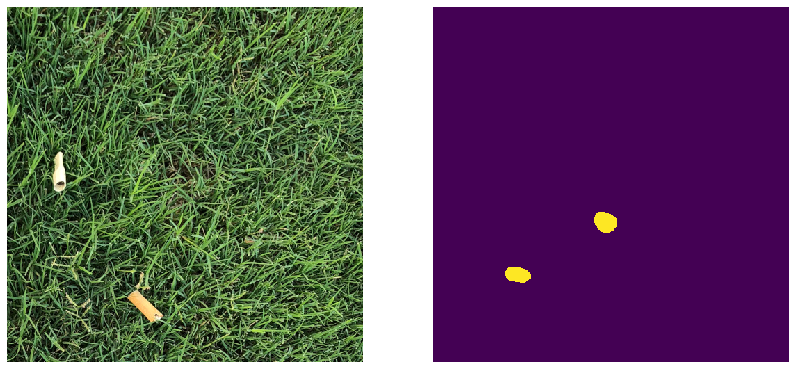

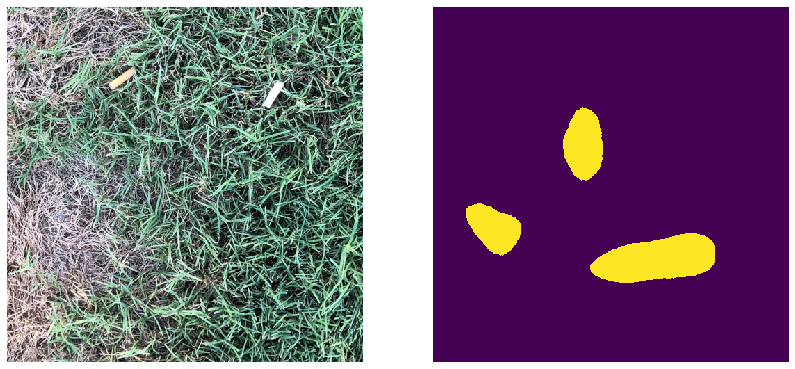

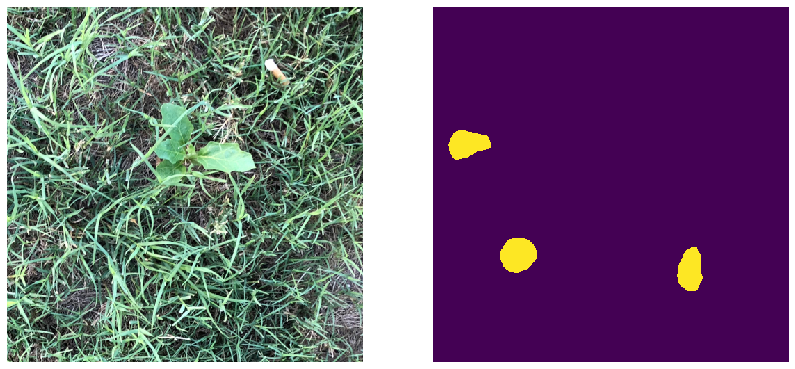

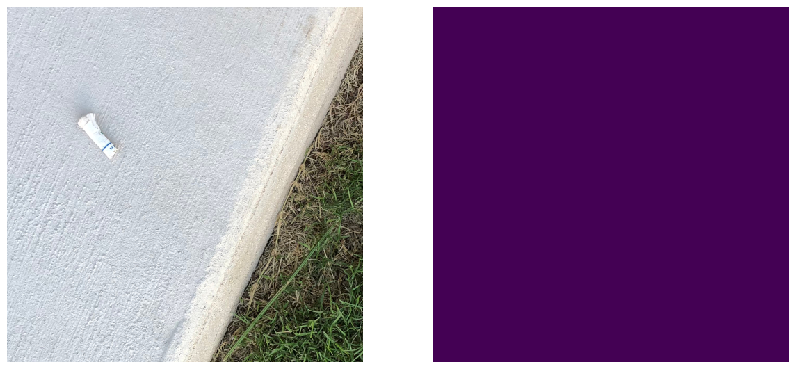

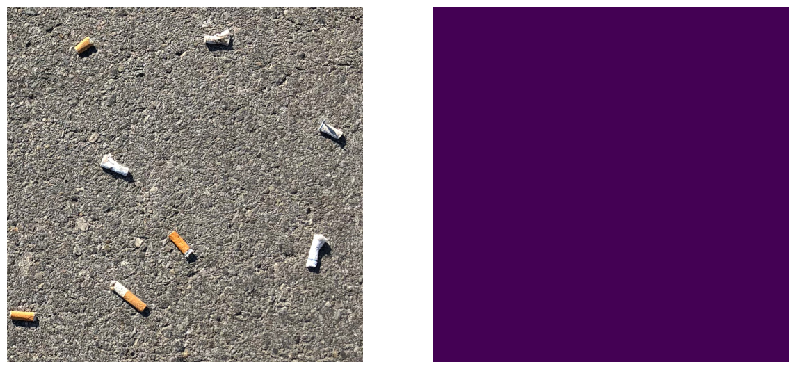

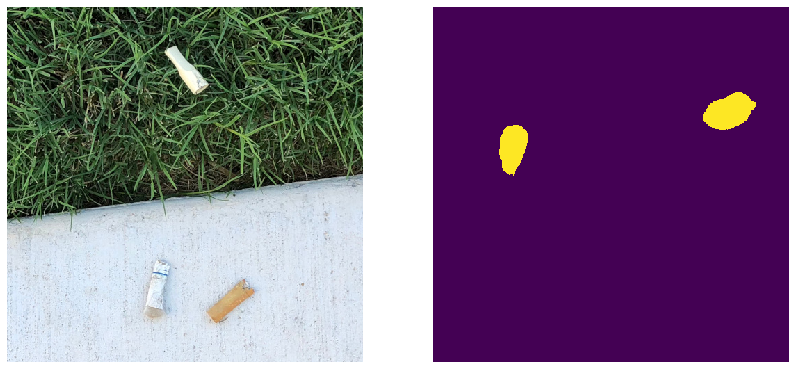

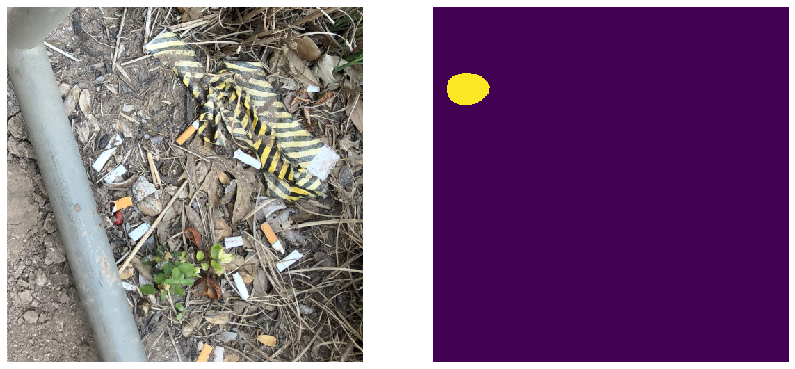

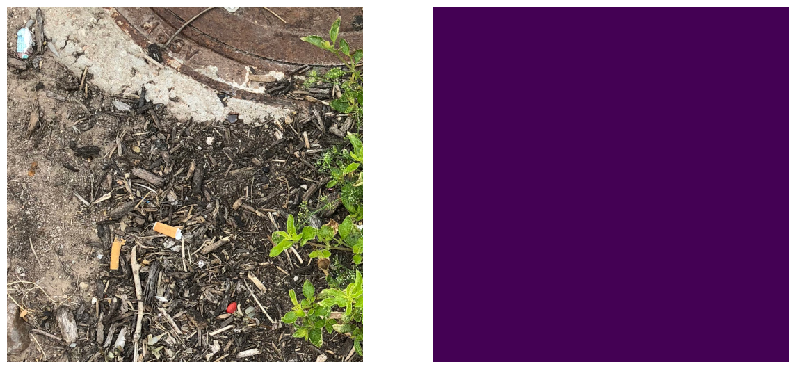

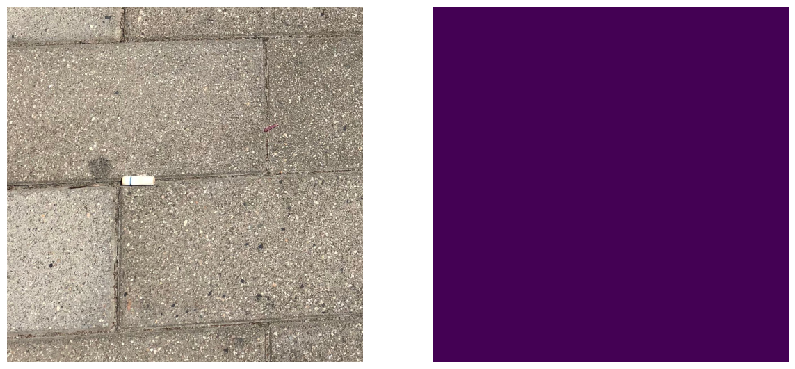

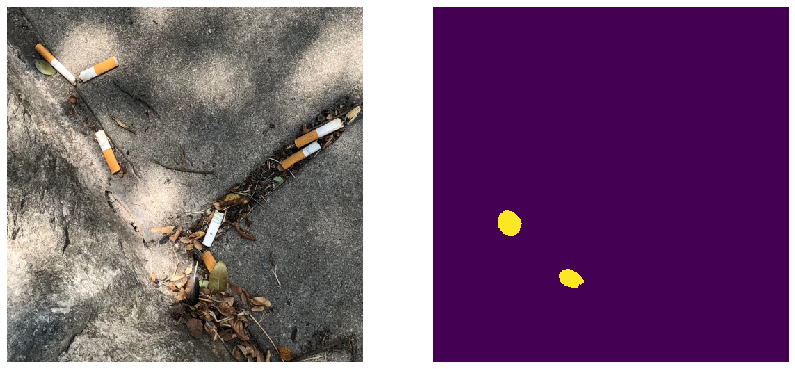

In [11]:
th = 0.4
model.eval()
for img_id, src in enumerate(test_loader):
    mask = model(src.to(device))
    mask = mask.detach().cpu().numpy().reshape(512, 512)
    mask = (mask >= th).astype(int)
    mask = mask*255
    img = np.array(Image.open(f"{test_path}/{img_id:04}.jpg"))
    show_img_with_mask(img, mask)